In [1]:
## In order to run this notebook, GEOPANDAS and BOKEH must be installed. If you are using anaconda, this can be done
## by running the following commands in the anaconda promt: "conda install -c conda-forge geopandas" and "conda install bokeh"
## Alternatively with pip: "pip install git+git://github.com/geopandas/geopandas.git" and "pip install bokeh"

## Importing and naming


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pydst
dst = pydst.Dst(lang='en')


from bokeh.io import curdoc, output_notebook
from bokeh.models import Slider, HoverTool
from bokeh.layouts import widgetbox, row, column

,REGIONKODE,REGIONNAVN,KOMKODE,KOMNAVN,Landsel,Landskode,geometry
0,1084,Region Hovedstaden,0400,Bornholm,Bornholm,8,"(POLYGON ((891187.49 6118170.25, 891186.3 6118..."
1,1085,Region Sjælland,0259,Køge,Østsjælland,7,"(POLYGON ((702347.24 6155011.31, 702342.570000..."
2,1085,Region Sjælland,0350,Lejre,Østsjælland,7,"(POLYGON ((684542.65 6171881.69, 684546.91 617..."
3,1085,Region Sjælland,0265,Roskilde,Østsjælland,7,"(POLYGON ((694011.6900000001 6183259.77, 69402..."
4,1085,Region Sjælland,0269,Solrød,Østsjælland,7,"(POLYGON ((703151.55 6157196.08, 703152.15 615..."


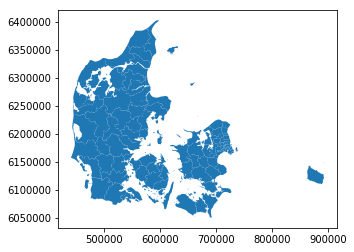

In [2]:
## KOM_MULTIPART.dbf , KOM_MULTIPART.shp and KOM_MULTIPART.shx must be placed 
## in the same folder as the saved notebook, in order for the code to work
## Read the GEO file
map_df = gpd.read_file("KOM_MULTIPART.shp")

## Plot the raw geodata
map_df.plot()

## Look the the structure of the geodata 
map_df.head()


In [3]:
## Look at the dataset FOD407

fod407_vars = dst.get_variables(table_id='FOD407')

fod407_vars

,elimination,id,map,text,time,values
0,True,OMRÅDE,denmark_municipality_07,region,False,"[{'id': '000', 'text': 'All Denmark'}, {'id': ..."
1,True,ALDER,NaN,age,False,"[{'id': 'TOT1', 'text': 'Total fertility rate'..."
2,False,Tid,NaN,time,True,"[{'id': '2006', 'text': '2006'}, {'id': '2007'..."


In [4]:
fod407_vars['values'][1][:] ## age= TOT1 to ONLY include all ages

[{'id': 'TOT1', 'text': 'Total fertility rate'},
 {'id': '15-19', 'text': '15-19 years'},
 {'id': '20-24', 'text': '20-24 years'},
 {'id': '25-29', 'text': '25-29 years'},
 {'id': '30-34', 'text': '30-34 years'},
 {'id': '35-39', 'text': '35-39 years'},
 {'id': '40-44', 'text': '40-44 years'},
 {'id': '45-49', 'text': '45-49 years'}]

In [5]:
## I load the fertility rate data via the API

fod407 = dst.get_data(table_id = 'FOD407', variables={'OMRÅDE':['*'], 'TID':['*'], 'ALDER':['TOT1'] })
fod407.head()

,OMRÅDE,TID,ALDER,INDHOLD
0,All Denmark,2006,Total fertility rate,1847.6
1,Region Hovedstaden,2006,Total fertility rate,1706.2
2,Region Sjælland,2006,Total fertility rate,2061.2
3,Region Syddanmark,2006,Total fertility rate,1928.0
4,Region Midtjylland,2006,Total fertility rate,1919.1


In [6]:
#I rename the used columns

fod407_en=fod407.rename(columns={"OMRÅDE": "AREA", "TID": "YEAR", "INDHOLD": "FertilityRate"})
fod407_en.head()

,AREA,YEAR,ALDER,FertilityRate
0,All Denmark,2006,Total fertility rate,1847.6
1,Region Hovedstaden,2006,Total fertility rate,1706.2
2,Region Sjælland,2006,Total fertility rate,2061.2
3,Region Syddanmark,2006,Total fertility rate,1928.0
4,Region Midtjylland,2006,Total fertility rate,1919.1


In [16]:
# Adjusting geo-names to merge properly

#d.sales[d.sales==24] = 100

fod407_en.loc[fod407_en.AREA=='Copenhagen', 'AREA'] = 'København'
fod407_en.loc[fod407_en.AREA=='Høje-Taastrup', 'AREA'] = 'Høje Taastrup'
fod407_en.head()

,AREA,YEAR,ALDER,FertilityRate
0,All Denmark,2006,Total fertility rate,1847.6
1,Region Hovedstaden,2006,Total fertility rate,1706.2
2,Region Sjælland,2006,Total fertility rate,2061.2
3,Region Syddanmark,2006,Total fertility rate,1928.0
4,Region Midtjylland,2006,Total fertility rate,1919.1


In [8]:
## I only want data from 1 year

fod407_en_1year=fod407_en[fod407_en['YEAR']==2018]   #.loc[(fod407.'YEAR' == '2018')]
fod407_en_1year.head()

,AREA,YEAR,ALDER,FertilityRate
1392,Middelfart,2018,Total fertility rate,1965.6
1393,Christiansø,2018,Total fertility rate,..
1394,Assens,2018,Total fertility rate,2124.7
1395,Faaborg-Midtfyn,2018,Total fertility rate,1946.9
1396,Kerteminde,2018,Total fertility rate,1941.1


In [17]:
## I merge the fertility data on the geodata

#merged = map_df.set_index('KOMNAVN').join(fod407_en_1year.set_index('AREA')) #Alternate version of merge
merged = pd.merge(map_df, fod407_en_1year, how='left', left_on='KOMNAVN', right_on='AREA')

merged.head()

,REGIONKODE,REGIONNAVN,KOMKODE,KOMNAVN,Landsel,Landskode,geometry,AREA,YEAR,ALDER,FertilityRate
0,1084,Region Hovedstaden,0400,Bornholm,Bornholm,8,"(POLYGON ((891187.49 6118170.25, 891186.3 6118...",Bornholm,2018,Total fertility rate,1762.6
1,1085,Region Sjælland,0259,Køge,Østsjælland,7,"(POLYGON ((702347.24 6155011.31, 702342.570000...",Køge,2018,Total fertility rate,2002.7
2,1085,Region Sjælland,0350,Lejre,Østsjælland,7,"(POLYGON ((684542.65 6171881.69, 684546.91 617...",Lejre,2018,Total fertility rate,2041.6
3,1085,Region Sjælland,0265,Roskilde,Østsjælland,7,"(POLYGON ((694011.6900000001 6183259.77, 69402...",Roskilde,2018,Total fertility rate,1805.2
4,1085,Region Sjælland,0269,Solrød,Østsjælland,7,"(POLYGON ((703151.55 6157196.08, 703152.15 615...",Solrød,2018,Total fertility rate,2305.4


In [10]:
# Does all geopoints have a fertility rate? Let's find out!!

missingrate=merged[merged['FertilityRate'] == '..']
print(missingrate['AREA'])

20           Læsø
24          Samsø
40            Ærø
42           Fanø
54    Christiansø
Name: AREA, dtype: object


In [11]:
## The variable to visualize on the map needs to be a string. Converted
merged.FertilityRate = merged.FertilityRate.astype(str)

## Additional dataset without the missing fertility rates
mergedNoMis=merged[merged['FertilityRate'] != '..']

## A map only looking at the capital region (minus Bornholm)
mergedCapReg=merged[merged['REGIONNAVN'] == 'Region Hovedstaden']
mergedCapReg2=mergedCapReg[mergedCapReg['KOMNAVN'] != 'Bornholm']

In [12]:
## The variable to visualize after is defined here
VisVar = 'FertilityRate'

# set the range for the choropleth - this will be consistent for all plots of the same variable
vmin, vmax = mergedNoMis['FertilityRate'].min() , merged['FertilityRate'].max()
vmin, vmax

('1520.0', '2437.6')

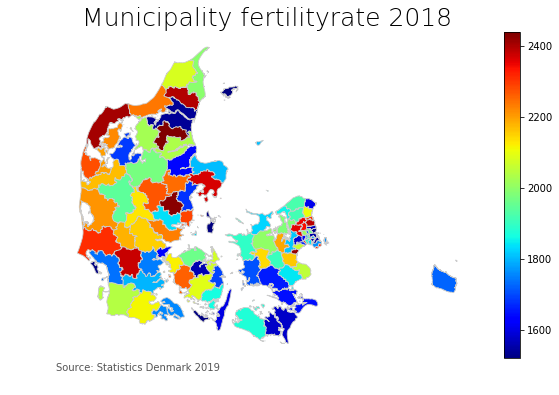

In [13]:
## Plot of all the data - including missing

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')

# add a title
ax.set_title('Municipality fertilityrate 2018', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# create an annotation for the  data source
ax.annotate('Source: Statistics Denmark 2019',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=10, color='#555555')

## The actual plot is created
merged.plot(column=VisVar,  cmap='jet', linewidth=0.8, ax=ax, edgecolor='0.8')

## The color scale on the right is created in relation to the data
sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

## The figure is saved in the folder
fig.savefig('testmap.png', dpi=300)

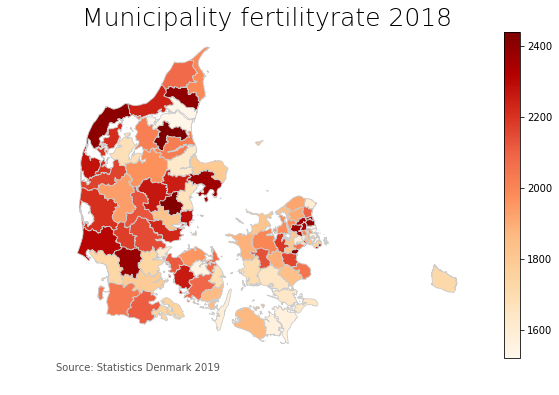

In [14]:
## With missings removed, Læsø, Samsø, Ærø, Fanø and Christiansø is lost.

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')

# add a title
ax.set_title('Municipality fertilityrate 2018', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# create an annotation for the  data source
ax.annotate('Source: Statistics Denmark 2019',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=10, color='#555555')

## The actual plot is created
mergedNoMis.plot(column=VisVar,  cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')

## The color scale on the right is created in relation to the data
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

## The figure is saved in the folder
fig.savefig('testmap.png', dpi=300)

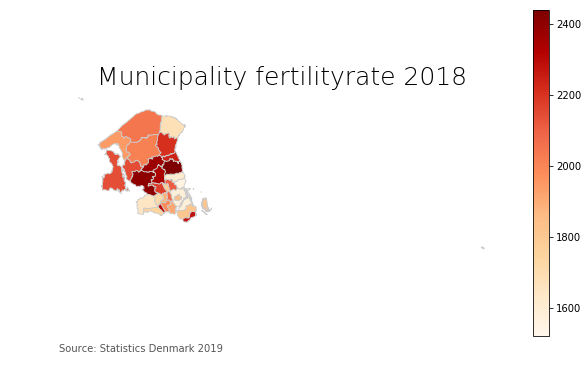

In [15]:
## Only the capital region, also excluding Bornholm.

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')

# add a title
ax.set_title('Municipality fertilityrate 2018', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# create an annotation for the  data source
ax.annotate('Source: Statistics Denmark 2019',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=10, color='#555555')

## The actual plot is created
mergedCapReg2.plot(column=VisVar,  cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')

## The color scale on the right is created in relation to the data
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

## The figure is saved in the folder
fig.savefig('testmap.png', dpi=300)

In [ ]:
## Next step is perhaps 
# https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0 